In [2]:
import dataset_utils as dataset

import torch as t

from ML_cup.pytorch import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
# Check if GPU is available
if torch.cuda.is_available():
    torch.set_default_device(torch.device("cuda"))


In [4]:

#column_names = ['ID', 
#                'INPUT_1', 'INPUT_2', 'INPUT_3', 'INPUT_4', 'INPUT_5', 'INPUT_6', 'INPUT_7', 'INPUT_8', 'INPUT_9', 'INPUT_10',
#                'TARGET_x', 'TARGET_y', 'TARGET_z']
#dataframe = pd.read_csv("../data/ML-CUP23-TR.csv", sep=',', comment='#', names=column_names, index_col= 'ID')
#dataframe.head()

dev_data = dataset.load_dataset("../data/ML-CUP23-TR.csv")
blind_data = dataset.load_dataset("../data/ML-CUP23-TS.csv")

# arange the dataset into inputs and labels
from dataset_utils import arange_datasets, train_val_kfold

X_dev, y_dev, X_blind = arange_datasets(dev_data, blind_data)
train_folds, val_folds = train_val_kfold(X_dev, y_dev, folds=5, random_state=42)

In [4]:
# Split the dev data into train and validation with k-fold cross validation and minibatch
train_loaders, val_loaders = dataset.torch_k_fold(dataset=dev_data, folds=5, batch_size=32)

In [5]:
parameters = [
    {'optimizer': 'SGD', 'lr': [0.01, 0.001, 0.0001], 'weight_decay': [0.0, 0.001, 0.0005], 'momentum': [0.9, 0.75],
     'nesterov': [True, False]}
]
lr_scheduler_params = {'mode': 'min', 'factor': 0.75, 'patience': 5, 'cooldown': 3, 'verbose': False, 'min_lr': 1e-6}
# perform grid search to find the best parameters
best_pytorch_params = grid_search(model_builder=MLP, parameters=parameters, train_loader=train_loaders,
                                  val_loader=val_loaders, scheduler=('ReduceLROnPlateau', lr_scheduler_params),
                                  verbose=False)

New Best Parameters: {'lr': 0.01, 'weight_decay': 0.0, 'momentum': 0.9, 'nesterov': True, 'optimizer': 'SGD'},Train Loss: 1.1972158025689423, Val Loss: 5.895060278688159
New Best Parameters: {'lr': 0.01, 'weight_decay': 0.0, 'momentum': 0.9, 'nesterov': False, 'optimizer': 'SGD'},Train Loss: 0.07748787032812834, Val Loss: 1.9454757860728669
New Best Parameters: {'lr': 0.01, 'weight_decay': 0.0, 'momentum': 0.75, 'nesterov': True, 'optimizer': 'SGD'},Train Loss: 0.03137463644891977, Val Loss: 0.9322064182588032
New Best Parameters: {'lr': 0.01, 'weight_decay': 0.0, 'momentum': 0.75, 'nesterov': False, 'optimizer': 'SGD'},Train Loss: 0.030010472320020198, Val Loss: 0.4648748244558062
New Best Parameters: {'lr': 0.01, 'weight_decay': 0.001, 'momentum': 0.75, 'nesterov': False, 'optimizer': 'SGD'},Train Loss: 0.03149916678667068, Val Loss: 0.4149917987840516
New Best Parameters: {'lr': 0.01, 'weight_decay': 0.0005, 'momentum': 0.75, 'nesterov': False, 'optimizer': 'SGD'},Train Loss: 0.0322

Fold: 0
Train Epoch: 0 Loss: 240.6742514038086 Val Loss: 51.79459653581892
Train Epoch: 1 Loss: 37.456099395751956 Val Loss: 24.05504035949707
Train Epoch: 2 Loss: 20.51105411529541 Val Loss: 14.361214092799596
Train Epoch: 3 Loss: 12.993866405487061 Val Loss: 9.690468175070626
Train Epoch: 4 Loss: 10.010523872375488 Val Loss: 8.04584653036935
Train Epoch: 5 Loss: 6.912547969818116 Val Loss: 4.278453316007342
Train Epoch: 6 Loss: 4.467487201690674 Val Loss: 4.507401943206787
Train Epoch: 7 Loss: 4.058024854660034 Val Loss: 4.364318915775844
Train Epoch: 8 Loss: 3.2315804958343506 Val Loss: 3.2299184799194336
Train Epoch: 9 Loss: 2.5523521661758424 Val Loss: 2.453145810535976
Train Epoch: 10 Loss: 2.151869397163391 Val Loss: 3.0821960823876515
Train Epoch: 11 Loss: 1.6337756276130677 Val Loss: 1.6706329839570182
Train Epoch: 12 Loss: 1.2400284290313721 Val Loss: 1.4511525460651942
Train Epoch: 13 Loss: 1.1292742705345153 Val Loss: 1.0740398594311305
Train Epoch: 14 Loss: 0.9607812011241

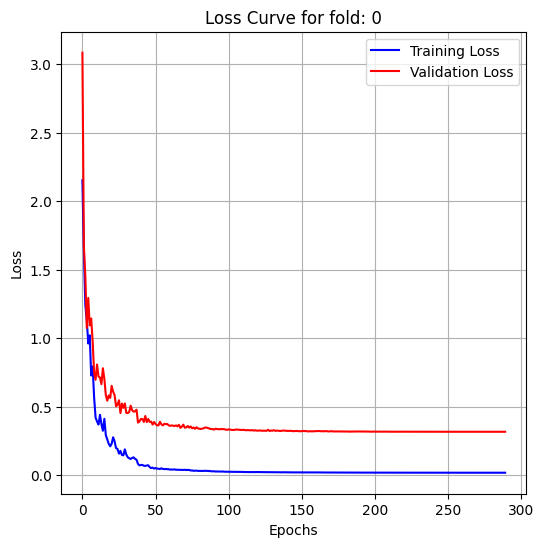

(0.018201254270970822, 0.31688699977738516)

In [5]:

best_pytorch_params = {'lr': 0.01, 'weight_decay': 0.0005, 'momentum': 0.75, 'nesterov': False, 'optimizer': 'SGD'}
# retrain the model with the best parameters
best_model = MLP()
train_loader, val_loader = dataset.torch_split_dataset(dataset=dev_data, train_ratio=0.8, batch_size=32)
if best_pytorch_params['optimizer'] == 'SGD':
    optimizer = t.optim.SGD(best_model.parameters(), lr=best_pytorch_params['lr'],
                            weight_decay=best_pytorch_params['weight_decay'], momentum=best_pytorch_params['momentum'],
                            nesterov=best_pytorch_params['nesterov'])
else:
    optimizer = t.optim.Adam(best_model.parameters(), lr=best_pytorch_params['lr'],
                             weight_decay=best_pytorch_params['weight_decay'])

torch_train(model=best_model, optimizer=optimizer, train_loader=train_loader,
            val_loader=val_loader, epochs=300,
            verbose=True,
            scheduler=lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.75, patience=5, cooldown=3,
                                                     verbose=True, min_lr=1e-6))

In [6]:
'''test_loader = DataLoader(CupDataset(blind_data))

# plot twist, it's only the inputs

# Evaluate the trained model on the test set
model = best_model
model.eval()  # Set the model to evaluation mode

outputs = []
with torch.no_grad():
    for inputs, labels in test_loader:
        output = model(inputs)
        outputs.append(output)

outputs'''

"test_loader = DataLoader(CupDataset(blind_data))\n\n# plot twist, it's only the inputs\n\n# Evaluate the trained model on the test set\nmodel = best_model\nmodel.eval()  # Set the model to evaluation mode\n\noutputs = []\nwith torch.no_grad():\n    for inputs, labels in test_loader:\n        output = model(inputs)\n        outputs.append(output)\n\noutputs"